# NYC Taxi Fare Prediction

## Pre-requisites

### Imports

In [1]:
# Std lib imports
import os
import re

# os.environ["MODIN_ENGINE"] = "ray"  # Modin will use Ray

# Dataset manipulation imports
import pandas as pd
# import modin.pandas as pd
import numpy as np

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
import datashader as ds
import datashader.transfer_functions as tf
from datashader.colors import inferno

# Geo calculation imports
from geopy.distance import great_circle

sns.set_theme(style="darkgrid")

# Scikit Learn
import sklearn.model_selection 
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Display imports
from IPython.display import display, HTML



###  Constants

In [2]:
ROOT_DIR = '/home/yashjethmalani'
SSD_ROOT_DIR = '/mnt/disks/ssd'
DATASET_DIR = SSD_ROOT_DIR +'/dataset'
nrows = None

dtypes = {
    'fare_amount': 'float32'
    , 'pickup_longitude': 'float32'
    , 'pickup_latitude': 'float32'
    , 'dropoff_longitude': 'float32'
    , 'dropoff_latitude': 'float32'
    , 'passenger_count': 'uint8'
}

columns = [
    'fare_amount'
    , 'pickup_datetime'
    , 'pickup_longitude'
    , 'pickup_latitude'
    , 'dropoff_longitude'
    , 'dropoff_latitude'
    , 'passenger_count'
] 

UNITS_MAPPING = [
    (1<<50, ' PB'),
    (1<<40, ' TB'),
    (1<<30, ' GB'),
    (1<<20, ' MB'),
    (1<<10, ' KB'),
    (1, (' byte', ' bytes')),
]

###  Utils

In [3]:
# Read csv with predefined dtypes and datetime conversion
def get_df(path, nrows, cols):
    df = pd.read_csv(path
#                      , dtype=dtypes
#                      , usecols=cols
                     , nrows=nrows
                    ).drop('key', axis=1).drop('pickup_datetime', axis=1)
    
    return df

def optimize_memory_usage(df):
    # Converting types to more effecient dtypes
    df.fare_amount = df.fare_amount.astype('float32')
    df.passenger_count = df.passenger_count.astype('int8')
    df.pickup_longitude = df.pickup_longitude.astype('float32')
    df.pickup_latitude = df.pickup_latitude.astype('float32')
    df.dropoff_longitude = df.dropoff_longitude.astype('float32')
    df.dropoff_latitude = df.dropoff_latitude.astype('float32')
    #df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

    # Setting index as datetime
    # df.set_index('key', inplace=True)
    return df

def pretty_size(bytes, units=UNITS_MAPPING):
    """Get human-readable file sizes.
    simplified version of https://pypi.python.org/pypi/hurry.filesize/
    """
    for factor, suffix in units:
        if bytes >= factor:
            break
    amount = int(bytes / factor)

    if isinstance(suffix, tuple):
        singular, multiple = suffix
        if amount == 1:
            suffix = singular
        else:
            suffix = multiple
    return str(amount) + suffix

## Training dataset

In [4]:
%%time

train_df = get_df(DATASET_DIR + '/train.csv', nrows, columns)

CPU times: user 1min 33s, sys: 17.6 s, total: 1min 50s
Wall time: 1min 55s


In [5]:
%%time

train_df = optimize_memory_usage(train_df)

CPU times: user 1.79 s, sys: 961 ms, total: 2.75 s
Wall time: 2.75 s


### Description

In [6]:
train_df.shape

(55423856, 6)

In [7]:
train_df.head(5)

fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
0          4.5        -73.844315        40.721317         -73.841614   
1         16.9        -74.016045        40.711304         -73.979271   
2          5.7        -73.982735        40.761269         -73.991241   
3          7.7        -73.987129        40.733143         -73.991570   
4          5.3        -73.968094        40.768009         -73.956657   

   dropoff_latitude  passenger_count  
0         40.712276                1  
1         40.782005                1  
2         40.750561                2  
3         40.758091                1  
4         40.783764                1

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55423856 entries, 0 to 55423855
Data columns (total 6 columns):
 #   Column             Dtype  
---  ------             -----  
 0   fare_amount        float32
 1   pickup_longitude   float32
 2   pickup_latitude    float32
 3   dropoff_longitude  float32
 4   dropoff_latitude   float32
 5   passenger_count    int8   
dtypes: float32(5), int8(1)
memory usage: 1.1 GB


In [9]:
train_df.describe()

fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
count  5.542386e+07      5.542386e+07     5.542386e+07       5.542348e+07   
mean   1.134503e+01     -7.250972e+01     3.991985e+01      -7.251106e+01   
std    2.071083e+01      1.284888e+01     9.642353e+00       1.278220e+01   
min   -3.000000e+02     -3.442060e+03    -3.492264e+03      -3.442025e+03   
25%    6.000000e+00     -7.399207e+01     4.073493e+01      -7.399140e+01   
50%    8.500000e+00     -7.398180e+01     4.075265e+01      -7.398015e+01   
75%    1.250000e+01     -7.396708e+01     4.076713e+01      -7.396368e+01   
max    9.396336e+04      3.457626e+03     3.408790e+03       3.457622e+03   

       dropoff_latitude  passenger_count  
count      5.542348e+07     5.542386e+07  
mean       3.992067e+01     1.685075e+00  
std        9.633346e+00     1.310116e+00  
min       -3.547887e+03    -1.270000e+02  
25%        4.073403e+01     1.000000e+00  
50%        4.075316e+01     1.000000e+00  
75%        4.076810e+01     2.000000e+00  
max        3.537133e+03     5.100000e+01

In [10]:
train_df.isna().sum()

fare_amount            0
pickup_longitude       0
pickup_latitude        0
dropoff_longitude    376
dropoff_latitude     376
passenger_count        0
dtype: int64

In [11]:
pd.set_option('use_inf_as_na', True)
train_df['fare_amount'] = train_df['fare_amount'].replace([np.inf, -np.inf], np.nan)
train_df = train_df[np.isfinite(train_df).all(1)]
train_df = train_df.dropna(subset=['fare_amount'], how='any')

In [12]:
train_df.shape

(55423480, 6)

In [13]:
train_df.describe()

fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
count  5.542348e+07      5.542348e+07     5.542348e+07       5.542348e+07   
mean   1.134501e+01     -7.250986e+01     3.991980e+01      -7.251120e+01   
std    2.071087e+01      1.284877e+01     9.642324e+00       1.278220e+01   
min   -3.000000e+02     -3.442060e+03    -3.492264e+03      -3.442025e+03   
25%    6.000000e+00     -7.399207e+01     4.073493e+01      -7.399140e+01   
50%    8.500000e+00     -7.398180e+01     4.075265e+01      -7.398015e+01   
75%    1.250000e+01     -7.396708e+01     4.076713e+01      -7.396368e+01   
max    9.396336e+04      3.457626e+03     3.408790e+03       3.457622e+03   

       dropoff_latitude  passenger_count  
count      5.542348e+07     5.542348e+07  
mean       3.992071e+01     1.685087e+00  
std        9.633346e+00     1.310113e+00  
min       -3.547887e+03    -1.270000e+02  
25%        4.073403e+01     1.000000e+00  
50%        4.075316e+01     1.000000e+00  
75%        4.076810e+01     2.000000e+00  
max        3.537133e+03     5.100000e+01

#### Passenger Count

In [14]:
train_df.passenger_count.describe()

count    5.542348e+07
mean     1.685087e+00
std      1.310113e+00
min     -1.270000e+02
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      5.100000e+01
Name: passenger_count, dtype: float64

#### Fare amount

In [15]:
train_df.fare_amount.describe()

count    5.542348e+07
mean     1.134501e+01
std      2.071087e+01
min     -3.000000e+02
25%      6.000000e+00
50%      8.500000e+00
75%      1.250000e+01
max      9.396336e+04
Name: fare_amount, dtype: float64

## Visualizations Utils

In [16]:
def plot_countplot(df_col, title, order=None):
    plt.figure(figsize = (12, 8))
    sns.countplot(df_col, order=order)
    plt.title(title)
    plt.show()
    
def plot_distplot(df_col, title):
    plt.figure(figsize = (12, 8))
    sns.distplot(df_col)
    plt.title(title)
    plt.show()
    
def plot_corr_matrix(df):
    corr = df.corr()
#     mask = np.triu(np.ones_like(corr, dtype=bool))
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr, cmap=cmap, vmax=.3, annot=True, fmt='.2f',
    center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
def plot_location(df, lng, lat, color_map):
    pickup_range = dropoff_range = x_range, y_range = ((-74.05, -73.7), (40.6, 40.85))
    cvs = ds.Canvas(plot_width = 1080, plot_height = 600, x_range = x_range, y_range = y_range)
    agg = cvs.points(df, lng, lat)
    img = tf.shade(agg, cmap = color_map, how = 'eq_hist')
    return tf.set_background(img, 'black')


def fare_amount_bin(df):
    df['fare_bin'] = df['fare_amount'].astype('int8')
    bins = list(range(0, 50, 5))
    df['fare_bin'] = pd.cut(df['fare_amount'], bins=bins).astype(str)
    df.loc[df['fare_bin'] == 'nan', 'fare_bin'] = '[45+]'
    df.loc[df['fare_bin'] == '(5.0, 10.0]', 'fare_bin'] = '(05.0, 10.0]'

#     plot_countplot(df['fare_bin'], 'Binned Fare Count Plot', order=df['fare_bin'].value_counts().index)
    plot_countplot(df['fare_bin'], 'Binned Fare Count Plot', order=sorted(df.fare_bin.unique()))

    return df

## Visualizations: Before Preprocecssing

### Passenger Count

/home/yashjethmalani/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


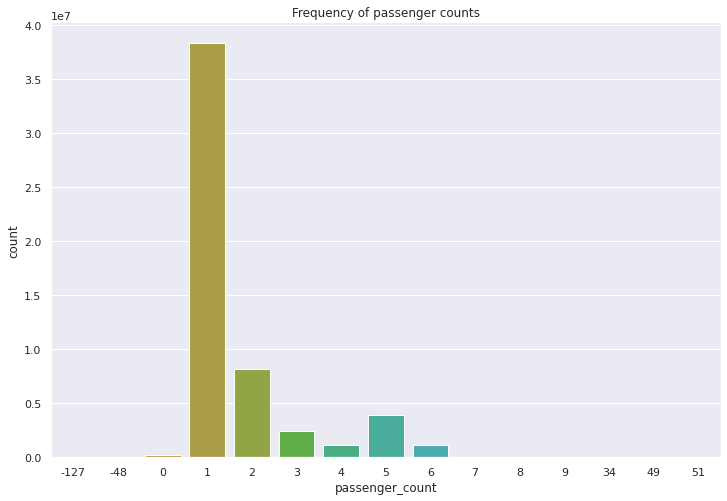

In [17]:
plot_countplot(train_df['passenger_count'], 'Frequency of passenger counts')


### Fare amount

/home/yashjethmalani/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


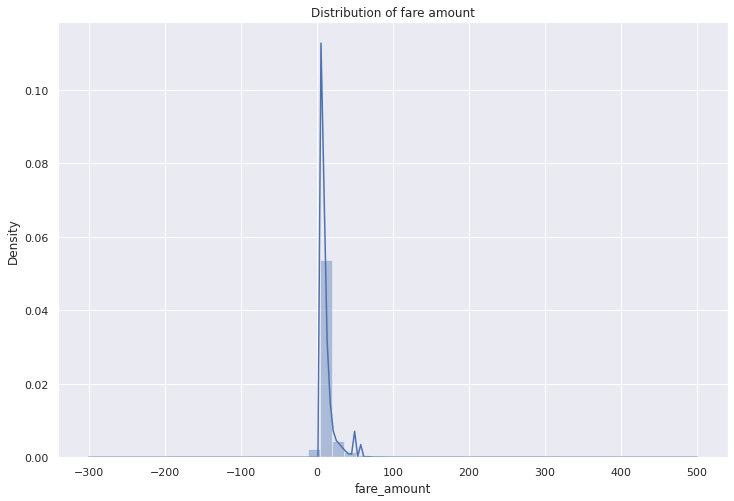

In [18]:
plot_distplot(train_df[train_df['fare_amount']<=500]['fare_amount'], 'Distribution of fare amount')



/home/yashjethmalani/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


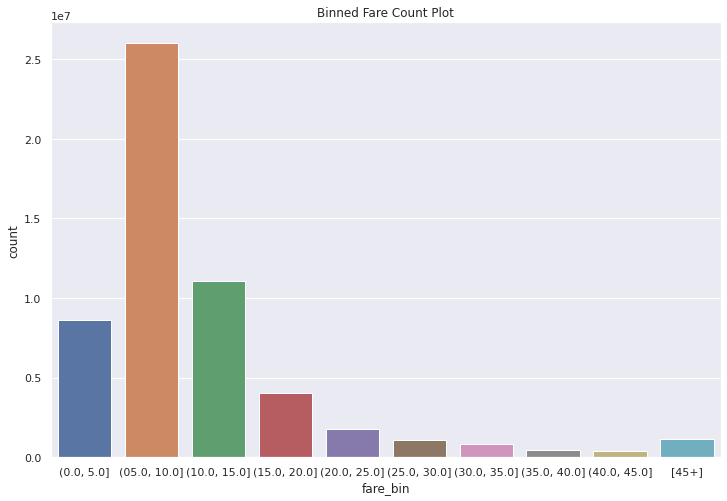

In [19]:
train_df = fare_amount_bin(train_df)

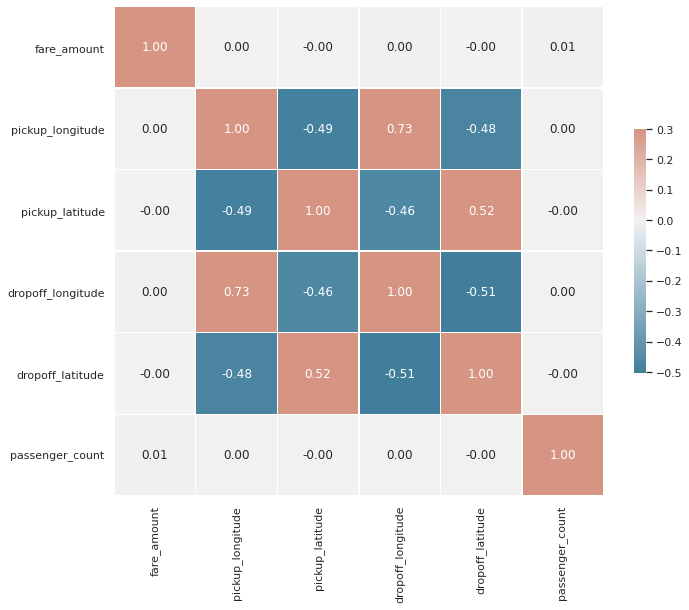

In [20]:
plot_corr_matrix(train_df)


### Pickup Plot

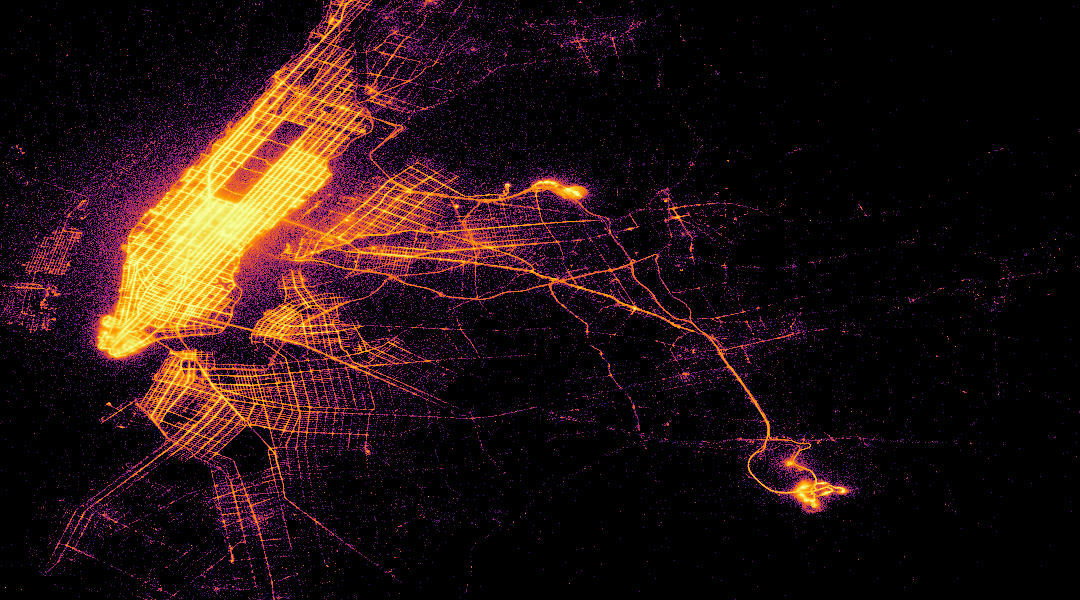

In [21]:
plot_location(train_df, 'pickup_longitude', 'pickup_latitude', inferno)


### Dropoff Plot

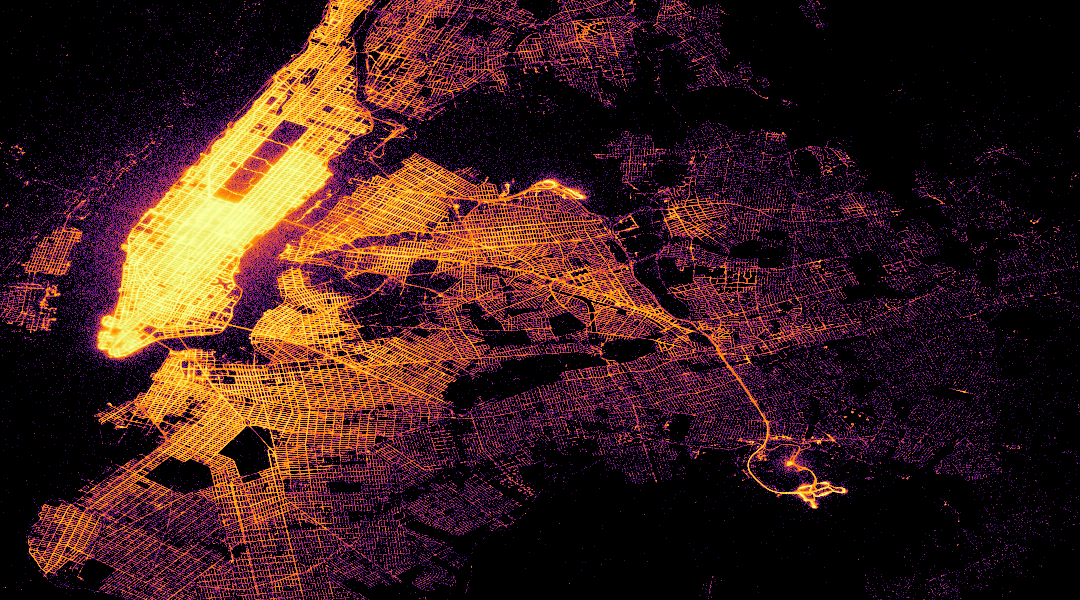

In [22]:
plot_location(train_df, 'dropoff_longitude', 'dropoff_latitude', inferno)


## Preprocessing

### Util

In [23]:
def haversine(lon1,lat1,lon2,lat2):
    R = 6371000 # Approximate mean radius of earth (in m)
    
    # Convert decimal degrees to ridians
    lon1,lat1,lon2,lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    
    # Distance of lons and lats in radians
    dis_lon = lon2 - lon1
    dis_lat = lat2 - lat1
    
    # Haversine implementation
    a = np.sin(dis_lat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dis_lon/2)**2
    c = 2*np.arctan2(np.sqrt(a), np.sqrt(1-a))
    dis_m = R*c # Distance in meters
    dis_km = dis_m/1000 # Distance in km
    return dis_km


def minkowski_distance(x1, x2, y1, y2, p):
    return ((abs(x2 - x1) ** p) + (abs(y2 - y1)) ** p) ** (1 / p)

def calc_relative_distance(df):

    # Add great_circle_distance
    df['haversine'] = haversine(df.pickup_longitude, 
                df.pickup_latitude, df.dropoff_longitude, df.dropoff_latitude)
    
    # Absolute difference in latitude and longitude
    df['abs_lat_diff'] = (df['dropoff_latitude'] - df['pickup_latitude']).abs()
    df['abs_lon_diff'] = (df['dropoff_longitude'] -df['pickup_longitude']).abs()
    
    # Add Manhattan Distance
    df['manhattan'] = minkowski_distance(df['pickup_longitude'], df['dropoff_longitude'],
                                       df['pickup_latitude'], df['dropoff_latitude'], 1)
    
    # Add Euclidean Distance
    df['euclidean'] = minkowski_distance(df['pickup_longitude'], df['dropoff_longitude'],
                                       df['pickup_latitude'], df['dropoff_latitude'], 2)
    
    return df


def extract_dateinfo(df, date_col, drop=True, time=False, 
                     start_ref = pd.datetime(1900, 1, 1),
                     extra_attr = False):
    """
    Extract Date (and time) Information from a DataFrame
    Adapted from: https://github.com/fastai/fastai/blob/master/fastai/structured.py
    """
    df = df.copy()
    
    # Extract the field
    fld = df[date_col]
    
    # Check the time
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    # Convert to datetime if not already
    if not np.issubdtype(fld_dtype, np.datetime64):
        df[date_col] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    

    # Prefix for new columns
    pre = re.sub('[Dd]ate', '', date_col)
    pre = re.sub('[Tt]ime', '', pre)
    
    # Basic attributes
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Days_in_month', 'is_leap_year']
    
    # Additional attributes
    if extra_attr:
        attr = attr + ['Is_month_end', 'Is_month_start', 'Is_quarter_end', 
                       'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    
    # If time is specified, extract time information
    if time: 
        attr = attr + ['Hour', 'Minute', 'Second']
        
    # Iterate through each attribute
    for n in attr: 
        df[pre + n] = getattr(fld.dt, n.lower())
        
    # Calculate days in year
    df[pre + 'Days_in_year'] = df[pre + 'is_leap_year'] + 365
        
    if time:
        # Add fractional time of day (0 - 1) units of day
        df[pre + 'frac_day'] = ((df[pre + 'Hour']) + (df[pre + 'Minute'] / 60) + (df[pre + 'Second'] / 60 / 60)) / 24
        
        # Add fractional time of week (0 - 1) units of week
        df[pre + 'frac_week'] = (df[pre + 'Dayofweek'] + df[pre + 'frac_day']) / 7
    
        # Add fractional time of month (0 - 1) units of month
        df[pre + 'frac_month'] = (df[pre + 'Day'] + (df[pre + 'frac_day'])) / (df[pre + 'Days_in_month'] +  1)
        
        # Add fractional time of year (0 - 1) units of year
        df[pre + 'frac_year'] = (df[pre + 'Dayofyear'] + df[pre + 'frac_day']) / (df[pre + 'Days_in_year'] + 1)
        
    # Add seconds since start of reference
    df[pre + 'Elapsed'] = (fld - start_ref).dt.total_seconds()
    
    if drop: 
        df = df.drop(date_col, axis=1)
        
    return df

def preprocess(df):
    # Drop rows with passenger count greater than 6. 
    # See NYC Taxi Driver Rule 54-15(g)
    df = df.loc[df['passenger_count'] < 7]
    df = df.loc[df['passenger_count'] > 0]
    
    # Drop fare_amount less than $2.5. Base fare for a cab is $2.5
    df = df[df.fare_amount>=2.5]
    df = df[df.fare_amount<=200]

    # Drop NAs
    df = df.dropna(how='any', axis='rows')
    
    df = df[df['pickup_latitude'] != 0]
    df = df[df['pickup_longitude'] != 0]
    df = df[df['dropoff_latitude'] != 0]
    df = df[df['dropoff_longitude'] != 0]

    df = df[(df['pickup_latitude']<=42) & (df['pickup_latitude']>=40)]
    df = df[(df['pickup_longitude']<=-72) & (df['pickup_longitude']>=-75)]
    df = df[(df['dropoff_latitude']<=42) & (df['dropoff_latitude']>=40)]
    df = df[(df['dropoff_longitude']<=-72) & (df['dropoff_longitude']>=-75)]

    # Convert timestamp to Year, Day, Month, etc.
#     df = extract_dateinfo(df
#                             , 'pickup_datetime'
#                             , drop=True
#                             , time=True
#                             , start_ref=df['pickup_datetime'].min())
    
    # TODO: Remove lat lng in water
    
    # TODO: Calculate distance in miles
    df = calc_relative_distance(df)
    
    return df

<ipython-input-23-08eba0ccde2d>:44: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  start_ref = pd.datetime(1900, 1, 1),


### Run Preprocecssing

In [24]:
train_df = preprocess(train_df)
train_df.head()

fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
0          4.5        -73.844315        40.721317         -73.841614   
1         16.9        -74.016045        40.711304         -73.979271   
2          5.7        -73.982735        40.761269         -73.991241   
3          7.7        -73.987129        40.733143         -73.991570   
4          5.3        -73.968094        40.768009         -73.956657   

   dropoff_latitude  passenger_count      fare_bin  haversine  abs_lat_diff  \
0         40.712276                1    (0.0, 5.0]   1.031069      0.009041   
1         40.782005                1  (15.0, 20.0]   8.449763      0.070702   
2         40.750561                2  (05.0, 10.0]   1.389644      0.010708   
3         40.758091                1  (05.0, 10.0]   2.799485      0.024948   
4         40.783764                1  (05.0, 10.0]   1.998886      0.015755   

   abs_lon_diff  manhattan  euclidean  
0      0.002701   0.011742   0.009436  
1      0.036774   0.107475   0.079693  
2      0.008507   0.019215   0.013676  
3      0.004440   0.029388   0.025340  
4      0.011436   0.027191   0.019468

## Visualizations: After Preprocessing

/home/yashjethmalani/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


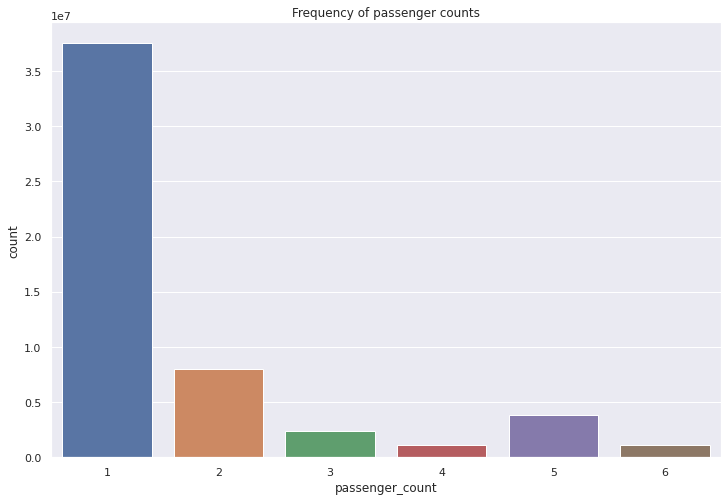

In [25]:
plot_countplot(train_df['passenger_count'], 'Frequency of passenger counts')

### Fare amount

/home/yashjethmalani/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


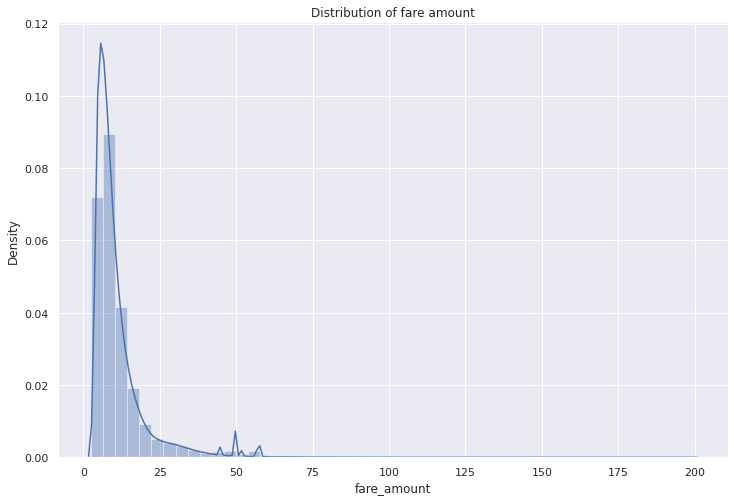

In [26]:
plot_distplot(train_df[train_df['fare_amount']<=500]['fare_amount'], 'Distribution of fare amount')

### Pickup Plot

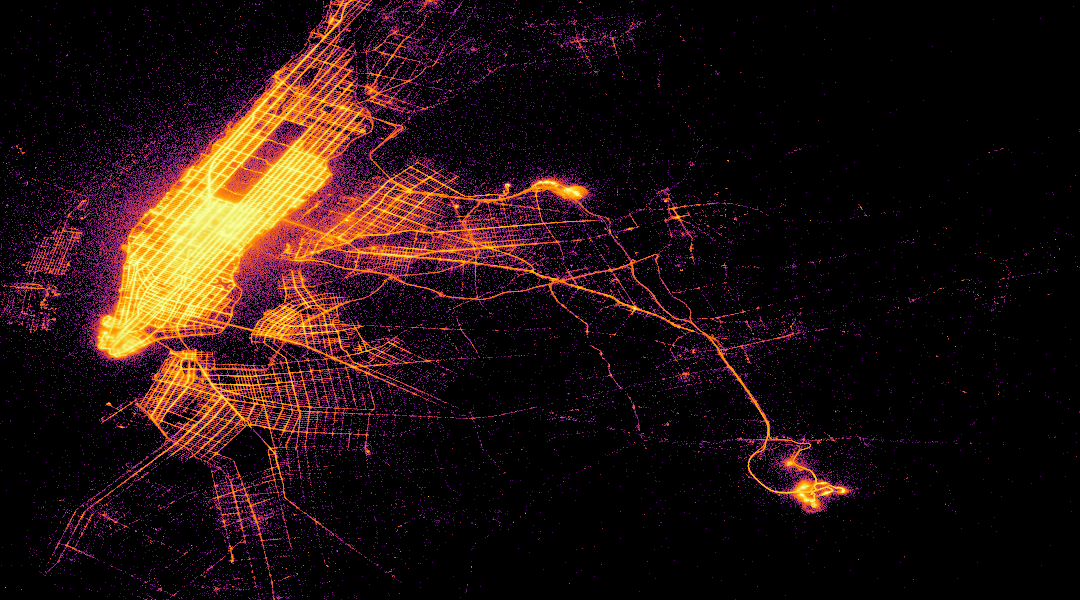

In [27]:
plot_location(train_df, 'pickup_longitude', 'pickup_latitude', inferno)

### Dropoff Plot

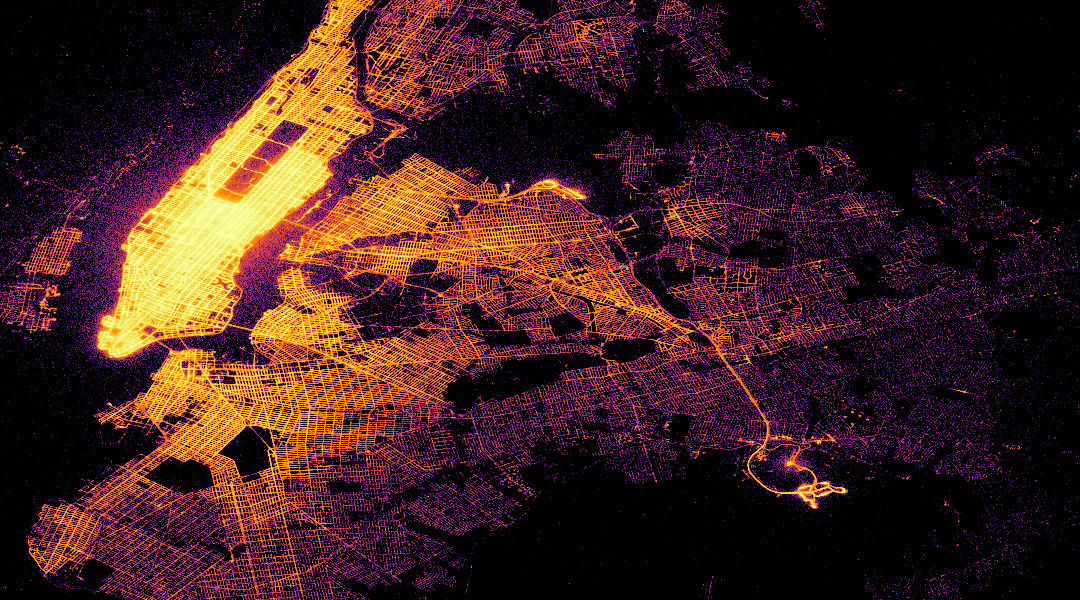

In [28]:
plot_location(train_df, 'dropoff_longitude', 'dropoff_latitude', inferno)

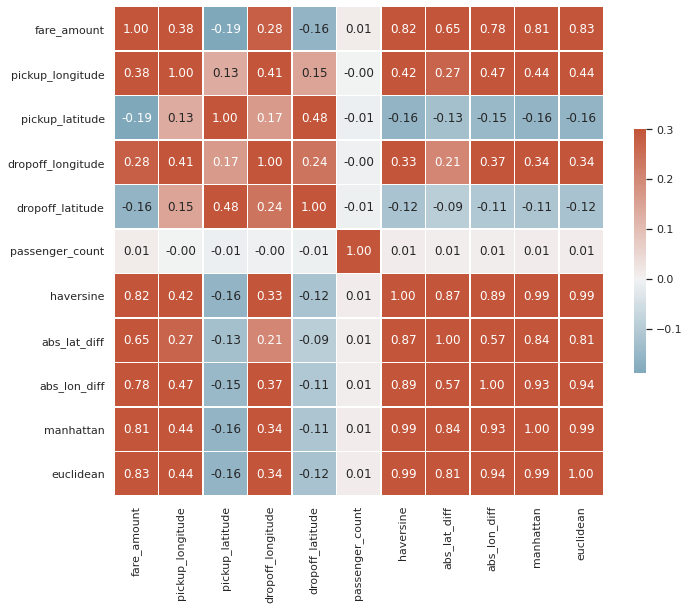

In [29]:
plot_corr_matrix(train_df)

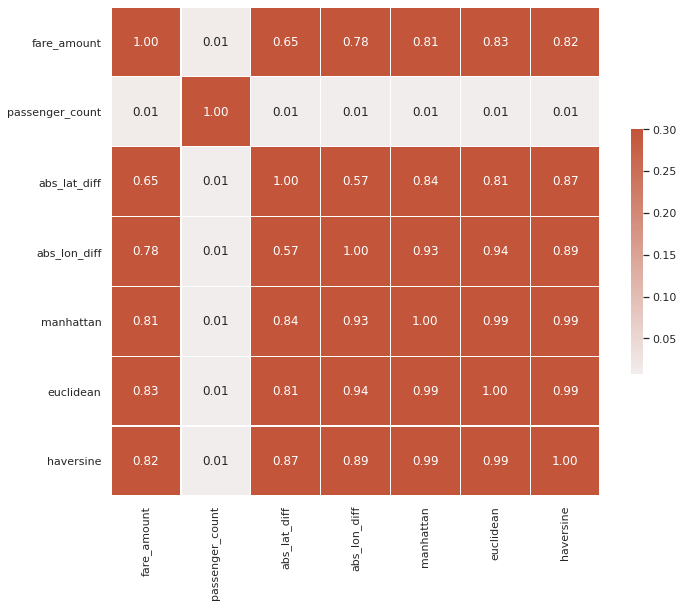

In [31]:
plot_corr_matrix(train_df[['fare_amount', 'passenger_count', 'abs_lat_diff', 'abs_lon_diff', 'manhattan', 'euclidean', 'haversine']])

In [30]:
train_df.head()

fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
0          4.5        -73.844315        40.721317         -73.841614   
1         16.9        -74.016045        40.711304         -73.979271   
2          5.7        -73.982735        40.761269         -73.991241   
3          7.7        -73.987129        40.733143         -73.991570   
4          5.3        -73.968094        40.768009         -73.956657   

   dropoff_latitude  passenger_count      fare_bin  haversine  abs_lat_diff  \
0         40.712276                1    (0.0, 5.0]   1.031069      0.009041   
1         40.782005                1  (15.0, 20.0]   8.449763      0.070702   
2         40.750561                2  (05.0, 10.0]   1.389644      0.010708   
3         40.758091                1  (05.0, 10.0]   2.799485      0.024948   
4         40.783764                1  (05.0, 10.0]   1.998886      0.015755   

   abs_lon_diff  manhattan  euclidean  
0      0.002701   0.011742   0.009436  
1      0.036774   0.107475   0.079693  
2      0.008507   0.019215   0.013676  
3      0.004440   0.029388   0.025340  
4      0.011436   0.027191   0.019468

## Train Test Split

In [31]:
# Split data
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(train_df
                                                                            , np.array(train_df['fare_amount'])
                                                                            , stratify=train_df['fare_bin']
                                                                            , random_state = 100, test_size = 0.3)

## Model Selection

### Evaluation Utils

In [32]:
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

def metrics(train_pred, test_pred, y_train, y_test):
    """Calculate metrics:
       Root mean squared error and mean absolute percentage error"""
    
    # Mean squared error
    train_mse = mean_squared_error(y_train, train_pred)
    test_mse = mean_squared_error(y_test, test_pred)
    
    # Root mean squared error
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    
    # R2 score
    train_r2 = r2_score(y_train, train_pred)
    test_r2 = r2_score(y_test, test_pred)
    
    # Calculate absolute percentage error
    train_ape = abs((y_train - train_pred) / y_train)
    test_ape = abs((y_test - test_pred) / y_test)
    
    # Account for y values of 0
    train_ape[train_ape == np.inf] = 0
    train_ape[train_ape == -np.inf] = 0
    test_ape[test_ape == np.inf] = 0
    test_ape[test_ape == -np.inf] = 0
    
    train_mape = 100 * np.mean(train_ape)
    test_mape = 100 * np.mean(test_ape)
    
    return train_mse, test_mse, train_rmse, test_rmse, train_r2, test_r2, train_mape, test_mape

def evaluate(model, features, X_train, X_test, y_train, y_test):
    """Mean absolute percentage error"""
    
    # Make predictions
    train_pred = model.predict(X_train[features])
    test_pred = model.predict(X_test[features])
    
    # Get metrics
    train_mse, test_mse, train_rmse, test_rmse, train_r2, test_r2, train_mape, test_mape = metrics(train_pred, test_pred,
                                                             y_train, y_test)
    
    training = [
        round(train_mse, 2)
        , round(train_rmse, 2)
        , round(train_r2, 2)
        , round(train_mape, 2)
    ]
    testing = [
        round(test_mse, 2)
        , round(test_rmse, 2)
        , round(test_r2, 2)
        , round(test_mape, 2)
    ]
    metric_labels = [
        'Mean Squared Error'
        , 'Root Mean Squared Error'
        , 'R2'
        , 'Mean Absolute Percentage Error'
    ]
    
    df = pd.DataFrame({"Training": training, "Testing": testing}, index=metric_labels)  
    display(HTML(df.to_html())) 

### Baseline Regression

In [33]:
dr = DummyRegressor(strategy="mean")

In [34]:
%%time

cols = ['abs_lat_diff', 'abs_lon_diff', 'passenger_count']
dr.fit(X_train[cols], y_train)

CPU times: user 195 ms, sys: 72.3 ms, total: 267 ms
Wall time: 266 ms


DummyRegressor()

In [35]:
%%time

evaluate(dr, cols, X_train, X_test, y_train, y_test)

CPU times: user 1.07 s, sys: 240 ms, total: 1.31 s
Wall time: 1.3 s


### Linear Regression Model 1 
features = (`abs_lat_diff`, `abs_lon_diff`, `passenger_count`)

In [36]:
lr = LinearRegression()#copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [37]:
%%time

cols = ['abs_lat_diff', 'abs_lon_diff', 'passenger_count']
lr.fit(X_train[cols], y_train)

print('Time taken to fit the model:')

Time taken to fit the model:
CPU times: user 2.45 s, sys: 436 ms, total: 2.89 s
Wall time: 2.34 s


In [38]:
print('Intercept:             ', round(lr.intercept_, 4))
print('abs_lat_diff coeff:    ', round(lr.coef_[0], 4))
print('abs_lon_diff coeff:    ', round(lr.coef_[1], 4))
print('passenger_count coeff: ', round(lr.coef_[2], 4))

Intercept:              4.9516
abs_lat_diff coeff:     117.3706
abs_lon_diff coeff:     166.5404
passenger_count coeff:  0.0425


In [39]:
%%time

evaluate(lr, cols, X_train, X_test, y_train, y_test)

CPU times: user 2.69 s, sys: 372 ms, total: 3.06 s
Wall time: 1.78 s


### Linear Regression Model 2
features = (`haversine`, `abs_lat_diff`, `abs_lon_diff`, `passenger_count`)

In [40]:
lr = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [41]:
%%time

cols = ['haversine', 'abs_lat_diff', 'abs_lon_diff', 'passenger_count']
lr.fit(X_train[cols], y_train)

print('Time taken to fit the model:')

Time taken to fit the model:
CPU times: user 3.97 s, sys: 1.15 s, total: 5.12 s
Wall time: 4.06 s


In [42]:
print('Intercept:             ', round(lr.intercept_, 4))
print('haversine coeff        ', round(lr.coef_[0], 4))
print('abs_lat_diff coeff:    ', round(lr.coef_[1], 4))
print('abs_lon_diff coeff:    ', round(lr.coef_[2], 4))
print('passenger_count coeff: ', round(lr.coef_[3], 4))

Intercept:              4.4476
haversine coeff         4.2903
abs_lat_diff coeff:     -239.8005
abs_lon_diff coeff:     -103.3969
passenger_count coeff:  0.0372


In [43]:
%%time

evaluate(lr, cols, X_train, X_test, y_train, y_test)

CPU times: user 3.33 s, sys: 867 ms, total: 4.2 s
Wall time: 2.79 s


### Linear Regression Model 3
features = (`manhattan`, `abs_lat_diff`, `abs_lon_diff`, `passenger_count`)

In [44]:
lr = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [45]:
%%time

cols = ['manhattan', 'abs_lat_diff', 'abs_lon_diff', 'passenger_count']
lr.fit(X_train[cols], y_train)

print('Time taken to fit the model:')

Time taken to fit the model:
CPU times: user 2.68 s, sys: 492 ms, total: 3.17 s
Wall time: 2.24 s


In [46]:
print('Intercept:             ', round(lr.intercept_, 4))
print('manhattan coeff        ', round(lr.coef_[0], 4))
print('abs_lat_diff coeff:    ', round(lr.coef_[1], 4))
print('abs_lon_diff coeff:    ', round(lr.coef_[2], 4))
print('passenger_count coeff: ', round(lr.coef_[3], 4))

Intercept:              4.9507
manhattan coeff         1633.9513
abs_lat_diff coeff:     -1516.5737
abs_lon_diff coeff:     -1467.3823
passenger_count coeff:  0.0425


In [47]:
%%time

evaluate(lr, cols, X_train, X_test, y_train, y_test)

CPU times: user 2.78 s, sys: 500 ms, total: 3.28 s
Wall time: 1.99 s


### Linear Regression Model 4
features = (`euclidean`, `abs_lat_diff`, `abs_lon_diff`, `passenger_count`)

In [48]:
lr = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [49]:
%%time

cols = ['euclidean', 'abs_lat_diff', 'abs_lon_diff', 'passenger_count']
lr.fit(X_train[cols], y_train)

print('Time taken to fit the model:')

Time taken to fit the model:
CPU times: user 2.64 s, sys: 517 ms, total: 3.16 s
Wall time: 2.26 s


In [50]:
print('Intercept:             ', round(lr.intercept_, 4))
print('euclidean coeff        ', round(lr.coef_[0], 4))
print('abs_lat_diff coeff:    ', round(lr.coef_[1], 4))
print('abs_lon_diff coeff:    ', round(lr.coef_[2], 4))
print('passenger_count coeff: ', round(lr.coef_[3], 4))

Intercept:              4.4757
euclidean coeff         425.7851
abs_lat_diff coeff:     -174.4194
abs_lon_diff coeff:     -176.3331
passenger_count coeff:  0.0372


In [51]:
%%time

evaluate(lr, cols, X_train, X_test, y_train, y_test)

CPU times: user 2.82 s, sys: 474 ms, total: 3.3 s
Wall time: 2.01 s


### Linear Regression Model 5
features = (`haversine`, `passenger_count`)

In [52]:
lr = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [53]:
%%time

cols = ['haversine', 'passenger_count']
lr.fit(X_train[cols], y_train)

print('Time taken to fit the model:')

Time taken to fit the model:
CPU times: user 2.5 s, sys: 604 ms, total: 3.11 s
Wall time: 2.35 s


In [54]:
print('Intercept:             ', round(lr.intercept_, 4))
print('haversine coeff        ', round(lr.coef_[0], 4))
print('passenger_count coeff: ', round(lr.coef_[1], 4))

Intercept:              4.2869
haversine coeff         2.0945
passenger_count coeff:  0.0377


In [55]:
%%time

evaluate(lr, cols, X_train, X_test, y_train, y_test)

CPU times: user 3.05 s, sys: 655 ms, total: 3.7 s
Wall time: 2.35 s


### Linear Regression Model 6
features = (`manhattan`, `passenger_count`)

In [56]:
lr = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [57]:
%%time

cols = ['manhattan', 'passenger_count']
lr.fit(X_train[cols], y_train)

print('Time taken to fit the model:')

Time taken to fit the model:
CPU times: user 1.66 s, sys: 280 ms, total: 1.94 s
Wall time: 1.24 s


In [58]:
print('Intercept:             ', round(lr.intercept_, 4))
print('manhattan coeff        ', round(lr.coef_[0], 4))
print('passenger_count coeff: ', round(lr.coef_[1], 4))

Intercept:              4.7377
manhattan coeff         147.6762
passenger_count coeff:  0.0413


In [59]:
%%time

evaluate(lr, cols, X_train, X_test, y_train, y_test)

CPU times: user 2.3 s, sys: 160 ms, total: 2.46 s
Wall time: 1.38 s


### Linear Regression Model 7
features = (`euclidean`, `passenger_count`)

In [60]:
lr = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [61]:
%%time

cols = ['euclidean', 'passenger_count']
lr.fit(X_train[cols], y_train)

print('Time taken to fit the model:')

Time taken to fit the model:
CPU times: user 1.57 s, sys: 320 ms, total: 1.89 s
Wall time: 1.22 s


In [62]:
print('Intercept:             ', round(lr.intercept_, 4))
print('euclidean coeff        ', round(lr.coef_[0], 4))
print('passenger_count coeff: ', round(lr.coef_[1], 4))

Intercept:              4.523
euclidean coeff         197.4451
passenger_count coeff:  0.0386


In [63]:
%%time

evaluate(lr, cols, X_train, X_test, y_train, y_test)

CPU times: user 2.27 s, sys: 152 ms, total: 2.42 s
Wall time: 1.37 s


# Random Forest

In [64]:
%%time

from sklearn.ensemble import RandomForestRegressor

# Create the random forest
random_forest = RandomForestRegressor(n_estimators = 20, max_depth = 20, 
                                      max_features = None, oob_score = True, 
                                      bootstrap = True, verbose = 1, n_jobs = -1)

# Train on data
random_forest.fit(X_train[['haversine', 'abs_lat_diff', 'abs_lon_diff', 'passenger_count']], y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 19.7min finished
/home/yashjethmalani/miniconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:832: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


CPU times: user 2h 19min 23s, sys: 44.9 s, total: 2h 20min 8s
Wall time: 22min 45s


RandomForestRegressor(max_depth=20, max_features=None, n_estimators=20,
                      n_jobs=-1, oob_score=True, verbose=1)

In [65]:
%%time

evaluate(random_forest, ['haversine', 'abs_lat_diff', 'abs_lon_diff', 'passenger_count'],
         X_train, X_test, y_train, y_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:   54.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:   23.1s finished


CPU times: user 8min 33s, sys: 16.4 s, total: 8min 49s
Wall time: 1min 21s


In [66]:
rf_pred = random_forest.predict(X_test[['haversine', 'abs_lat_diff', 'abs_lon_diff', 'passenger_count']])
count = len(rf_pred)
diff = 0.0
for i in range(0, count):
    diff += abs(y_test[i] - rf_pred[i])
    
error_margin = diff/count
print('error_margin: ', error_margin)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:   23.2s finished


error_margin:  2.2220659677240056


# XGBoost

In [71]:
%%time

from sklearn.ensemble import GradientBoostingRegressor

# Create the random forest
xGBoost = GradientBoostingRegressor(n_estimators = 20, max_depth = 2, learning_rate=0.2)

# Train on data
xGBoost.fit(X_train[['haversine', 'abs_lat_diff', 'abs_lon_diff', 'passenger_count']], y_train)

CPU times: user 17min 20s, sys: 17.6 s, total: 17min 37s
Wall time: 17min 38s


GradientBoostingRegressor(learning_rate=0.2, max_depth=2, n_estimators=20)

In [72]:
%%time

evaluate(xGBoost, ['haversine', 'abs_lat_diff', 'abs_lon_diff', 'passenger_count'],
         X_train, X_test, y_train, y_test)

CPU times: user 13 s, sys: 1.62 s, total: 14.7 s
Wall time: 14.7 s


# XGBoost

In [73]:
%%time

from sklearn.ensemble import GradientBoostingRegressor

# Create the random forest
xGBoost = GradientBoostingRegressor(n_estimators = 100, max_depth = 6, learning_rate=0.2)

# Train on data
xGBoost.fit(X_train[['haversine', 'abs_lat_diff', 'abs_lon_diff', 'passenger_count']], y_train)

CPU times: user 4h 18min 33s, sys: 1min 14s, total: 4h 19min 47s
Wall time: 4h 19min 48s


GradientBoostingRegressor(learning_rate=0.2, max_depth=6)

In [74]:
%%time

evaluate(xGBoost, ['haversine', 'abs_lat_diff', 'abs_lon_diff', 'passenger_count'],
         X_train, X_test, y_train, y_test)

CPU times: user 1min 47s, sys: 1.76 s, total: 1min 49s
Wall time: 1min 49s
